In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
from scipy import ndimage, misc
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.14.0


In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image

In [ ]:
SIZE = 512

In [ ]:
import shutil
SIZE = 512
high_img = []
#high_img_thresh=[]
path = '/content/drive/MyDrive/Roll_folder_512_final'
files = os.listdir(path)
files = sorted_alphanumeric(files)
tempFiles=files[:1000]
for i in tqdm(tempFiles):
            # Replace these paths with your actual file paths
        source_path = '/content/drive/MyDrive/Roll_256_damage_final/'+i
        destination_path = '/content/drive/MyDrive/Copied256sizeImage/'+i

        shutil.copy2(source_path, destination_path)
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        #high_img_thresh.append(img)
        high_img.append(img_to_array(img))

100%|██████████| 1000/1000 [00:18<00:00, 54.82it/s]


In [ ]:
low_img = []
#low_img_thresh=[]
path = '/content/drive/MyDrive/Roll_256_damage_final/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(tempFiles):

    if i == '855.jpg':
        break
    else:
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        #low_img_thresh.append(img)
        low_img.append(img_to_array(img))

100%|██████████| 1000/1000 [00:38<00:00, 26.04it/s]


In [ ]:
len(low_img)

1000

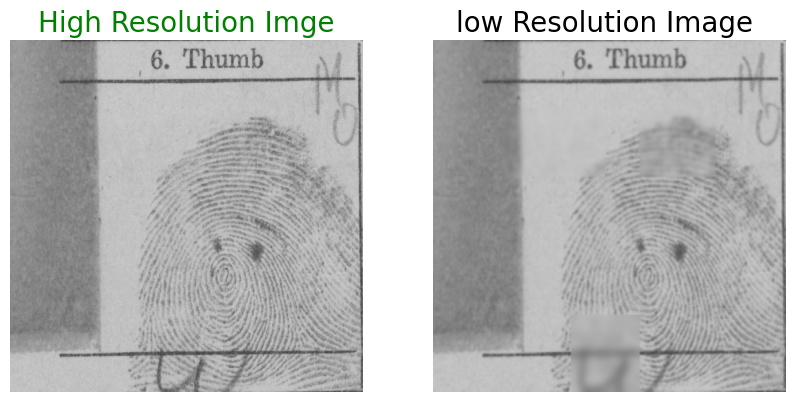

In [ ]:
for i in range(1):
    a = np.random.randint(0,105)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [ ]:
high_img.shape

AttributeError: ignored

In [ ]:

train_high_image = high_img[0:800]
train_low_image = low_img[0:800]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[800:900]
validation_low_image =  low_img[800:900]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[900:]
test_low_image = low_img[900:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (800, 512, 512, 3)
Shape of test images: (100, 512, 512, 3)
Shape of validation images: (100, 512, 512, 3)


In [ ]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 3)       2403      
                                                                 
Total params: 20099 (78.51 KB)
Trainable params: 20099 (78.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


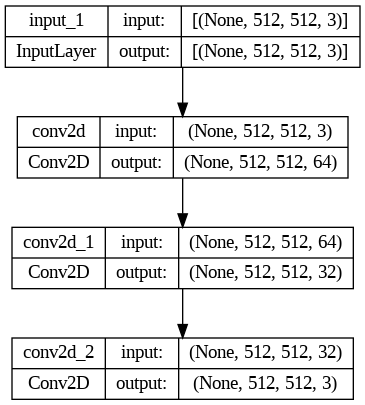

In [ ]:
from keras import layers

input_img=Input(shape=(512,512,3))
l1=tf.keras.layers.Conv2D(64,9,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(32,1,padding='same',activation='relu') (l1)
l3=tf.keras.layers.Conv2D(3,5,padding='same',activation='relu') (l2)


SRCNN=Model(input_img,l3)


def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )
SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss, metrics=[PSNR,'accuracy'])
SRCNN.summary()
plot_model(SRCNN, to_file ='super_res.png',show_shapes=True)

In [ ]:
SRCNN.save('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR_New.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
SRCNN.fit(train_low_image, train_high_image, epochs = 100, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/100
800/800 [==============================] - 29s 23ms/step - loss: 0.0083 - PSNR: 26.1532 - accuracy: 0.2937 - val_loss: 0.0015 - val_PSNR: 28.5554 - val_accuracy: 0.2275
Epoch 2/100
800/800 [==============================] - 17s 21ms/step - loss: 0.0013 - PSNR: 29.2068 - accuracy: 0.3096 - val_loss: 0.0014 - val_PSNR: 29.0710 - val_accuracy: 0.4401
Epoch 3/100
800/800 [==============================] - 17s 21ms/step - loss: 0.0012 - PSNR: 29.4328 - accuracy: 0.3451 - val_loss: 0.0013 - val_PSNR: 29.1957 - val_accuracy: 0.3225
Epoch 4/100
800/800 [==============================] - 17s 21ms/step - loss: 0.0013 - PSNR: 29.3327 - accuracy: 0.3446 - val_loss: 0.0013 - val_PSNR: 29.2302 - val_accuracy: 0.2238
Epoch 5/100
800/800 [==============================] - 17s 21ms/step - loss: 0.0013 - PSNR: 29.3899 - accuracy: 0.3585 - val_loss: 0.0016 - val_PSNR: 28.1945 - val_accuracy: 0.5804
Epoch 6/100
800/800 [==============================] - 18s 22ms/step - loss: 0.0012 - PSNR: 29.

In [ ]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
SRCNN = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR_New.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})


In [ ]:
tempFiles=tempFiles[900:]



In [ ]:
tempFiles

['00001225_roll_500_01.png',
 '00001225_roll_500_02.png',
 '00001225_roll_500_08.png',
 '00001225_roll_500_09.png',
 '00001225_roll_500_10.png',
 '00001226_roll_500_05.png',
 '00001226_roll_500_10.png',
 '00001227_roll_500_02.png',
 '00001227_roll_500_04.png',
 '00001227_roll_500_05.png',
 '00001227_roll_500_09.png',
 '00001228_roll_500_01.png',
 '00001228_roll_500_02.png',
 '00001228_roll_500_09.png',
 '00001228_roll_500_10.png',
 '00001229_roll_500_07.png',
 '00001230_roll_500_06.png',
 '00001231_roll_500_03.png',
 '00001231_roll_500_05.png',
 '00001231_roll_500_07.png',
 '00001231_roll_500_08.png',
 '00001231_roll_500_09.png',
 '00001232_roll_500_01.png',
 '00001232_roll_500_04.png',
 '00001232_roll_500_05.png',
 '00001232_roll_500_06.png',
 '00001232_roll_500_09.png',
 '00001233_roll_500_01.png',
 '00001233_roll_500_03.png',
 '00001233_roll_500_05.png',
 '00001233_roll_500_06.png',
 '00001233_roll_500_07.png',
 '00001233_roll_500_08.png',
 '00001233_roll_500_09.png',
 '00001233_rol

In [ ]:
save_path = os.path.join("/content/drive/MyDrive/Testing_Without_THR/Pred",tempFiles[i].split('/')[-1])
cv2.imwrite(pred_save_path, (predicted * 255).astype(np.uint8))  # Convert to 8-bit before saving

In [ ]:
from termcolor import colored
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()
path = '/content/drive/MyDrive/Copied256sizeImage/'
files_01 = os.listdir(path)
font_size = 50
for i in range(0,len(test_high_image)):
    predicted = np.clip(SRCNN.predict(low_img[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    pred_save_path = os.path.join("/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred",files_01[i].split('/')[-1])
    cv2.imwrite(pred_save_path, (predicted * 255).astype(np.uint8))  # Convert to 8-bit before saving
    high_save_path = os.path.join("/content/drive/MyDrive/Testing_Without_THR_SRCNN/High", files_01[i].split('/')[-1])
    cv2.imwrite(high_save_path, (high_img[i] * 255).astype(np.uint8))  # Convert to 8-bit before saving
    low_save_path = os.path.join("/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low", files_01[i].split('/')[-1])
    cv2.imwrite(low_save_path, (low_img[i] * 255).astype(np.uint8))  # Convert to 8-bit before saving
    #plot_images(high_img[i],low_img[i],predicted)

    #print('PSNR',PSNR(test_high_image[i],predicted).numpy(),'dB', "SSIM",tf.image.ssim(test_high_image[i],predicted,max_val=1))
    #print('PSNR',PSNR(high_img[i],predicted).numpy(),'dB')


1/1 [==============================] - 0s 20ms/step


In [ ]:
from skimage.metrics import structural_similarity as ssim
def evaluate_similarity(original_images, resized_images):
    original_gray = cv2.cvtColor(original_images, cv2.COLOR_BGR2GRAY)
    resized_gray = cv2.cvtColor(resized_images, cv2.COLOR_BGR2GRAY)
    similarity = ssim(original_gray, resized_gray)
    return similarity

In [ ]:
PSNR_values=[]
Similarities=[]
for i in range(0,len(test_high_image)):
    predicted = np.clip(SRCNN.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    #plot_images(test_high_image[i],test_low_image[i],predicted)

    #print('PSNR',PSNR(test_high_image[i],predicted).numpy(),'dB', "SSIM",tf.image.ssim(test_high_image[i],predicted,max_val=1))
    PSNR_values.append(PSNR(test_high_image[i],predicted).numpy())
    Similarities.append(evaluate_similarity(test_high_image[i], predicted))

avg_psnr= np.mean(PSNR_values)
avg_ssim=np.mean(Similarities)
print(f"Average PSNR {avg_psnr}")
print(f"Average SSIM:{avg_ssim}")

1/1 [==============================] - 0s 20ms/step
Average PSNR 29.75395965576172
Average SSIM:0.9164635601878861


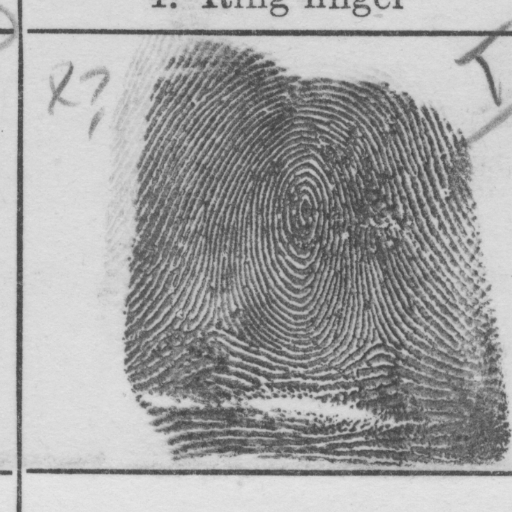

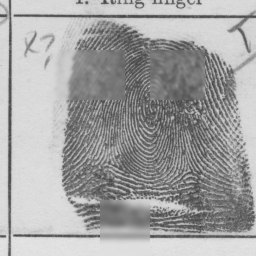

good_matches 447


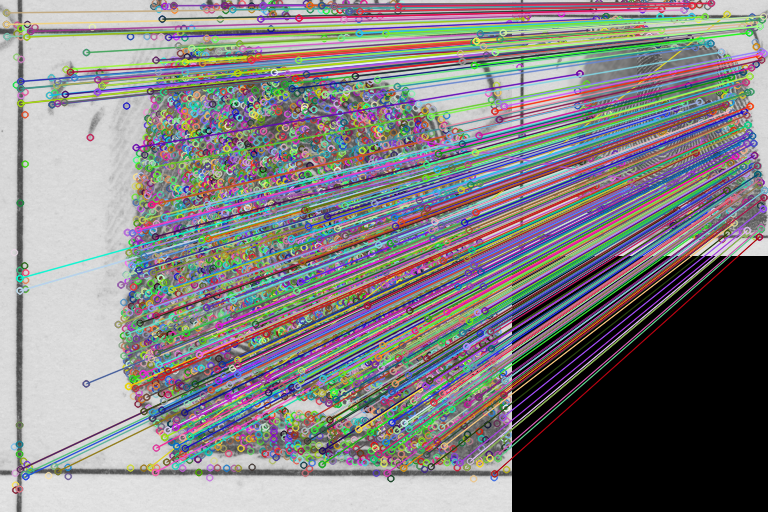

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

#file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
#file_list_low = os.listdir('/content/drive/MyDrive/Roll_256_damage_final')



filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/00001000_roll_500_04.png'
#cv2_imshow(filepath)
filepath_sample='/content/drive/MyDrive/Copied256sizeImage/00001000_roll_500_04.png'
#cv2_imshow(filepath_sample)
sample_1=cv2.imread(filepath)
sample=cv2.imread(filepath_sample)
cv2_imshow(sample_1)
cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
sift = cv2.SIFT_create()
keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
      good_matches.append(m)

            # Draw the matches
result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
print("good_matches",len(good_matches))

            # Show the result
cv2_imshow(result_image)

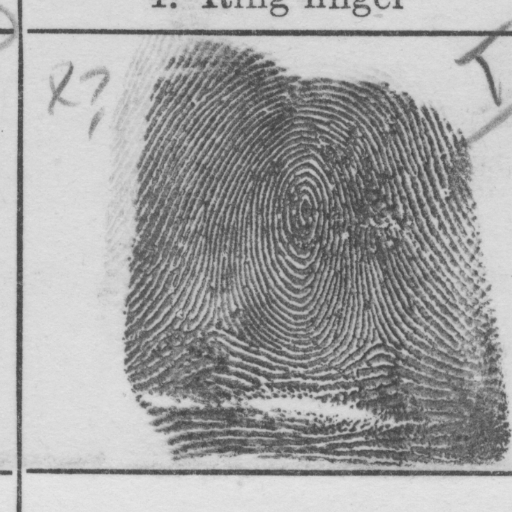

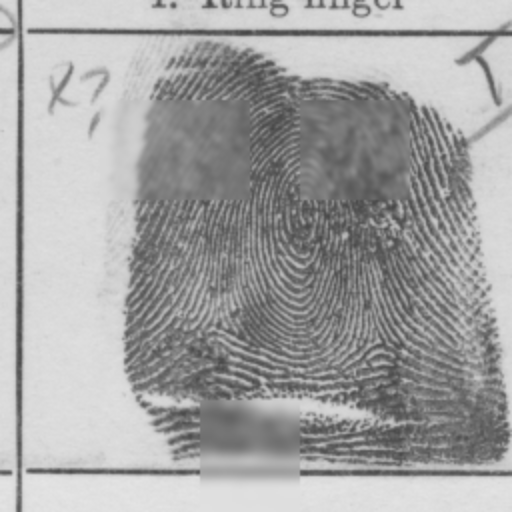

good_matches 1419


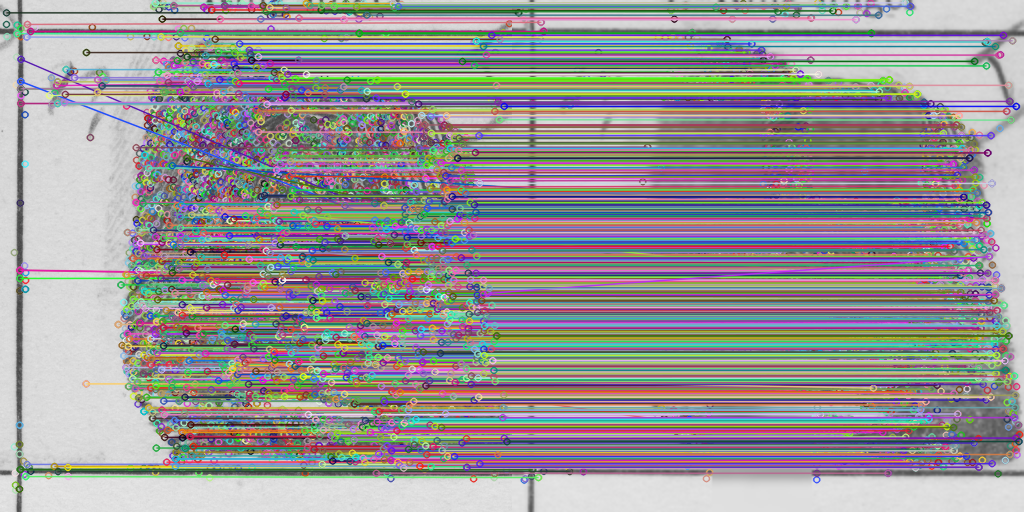

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

#file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
#file_list_low = os.listdir('/content/drive/MyDrive/Roll_256_damage_final')



filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/00001000_roll_500_04.png'
#cv2_imshow(filepath)
filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low/00001000_roll_500_04.png'
#cv2_imshow(filepath_sample)
sample_1=cv2.imread(filepath)
sample=cv2.imread(filepath_sample)
cv2_imshow(sample_1)
cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
sift = cv2.SIFT_create()
keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
      good_matches.append(m)

            # Draw the matches
result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
print("good_matches",len(good_matches))

            # Show the result
cv2_imshow(result_image)

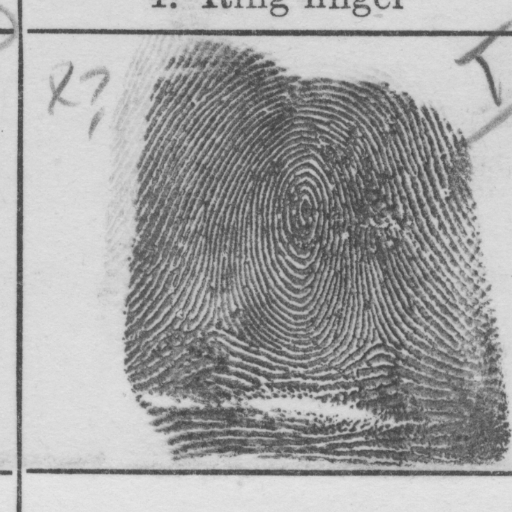

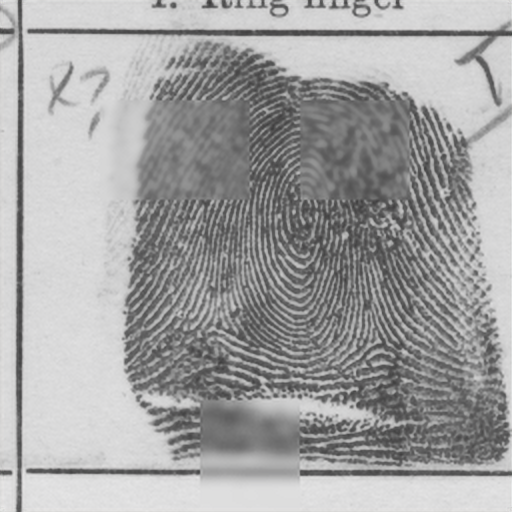

good_matches 2664


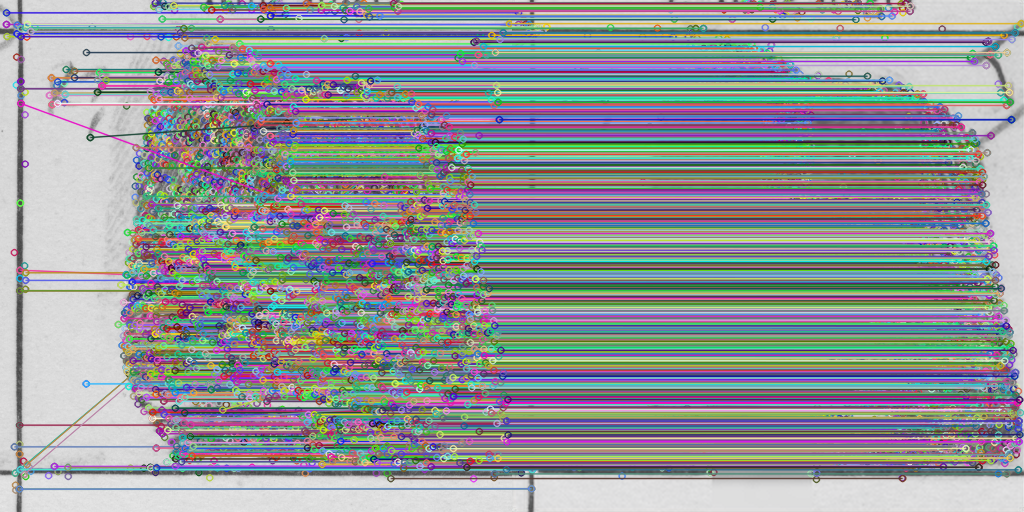

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

#file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
#file_list_low = os.listdir('/content/drive/MyDrive/Roll_256_damage_final')



filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/00001000_roll_500_04.png'
#cv2_imshow(filepath)
filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred/00001000_roll_500_04.png'
#cv2_imshow(filepath_sample)
sample_1=cv2.imread(filepath)
sample=cv2.imread(filepath_sample)
cv2_imshow(sample_1)
cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
sift = cv2.SIFT_create()
keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
      good_matches.append(m)

            # Draw the matches
result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
print("good_matches",len(good_matches))

            # Show the result
cv2_imshow(result_image)

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Copied256sizeImage/')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    filepath_sample='/content/drive/MyDrive/Copied256sizeImage/'+file_list_high[i]
    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:01<01:28,  1.82s/it]

good_matches 447


  4%|▍         | 2/50 [00:03<01:28,  1.84s/it]

good_matches 165


  6%|▌         | 3/50 [00:05<01:23,  1.78s/it]

good_matches 490


  8%|▊         | 4/50 [00:07<01:21,  1.78s/it]

good_matches 428


 10%|█         | 5/50 [00:08<01:11,  1.60s/it]

good_matches 341


 12%|█▏        | 6/50 [00:11<01:27,  1.98s/it]

good_matches 282


 14%|█▍        | 7/50 [00:12<01:20,  1.87s/it]

good_matches 243


 16%|█▌        | 8/50 [00:14<01:12,  1.72s/it]

good_matches 351


 18%|█▊        | 9/50 [00:15<01:07,  1.65s/it]

good_matches 283


 20%|██        | 10/50 [00:17<01:04,  1.62s/it]

good_matches 289


 22%|██▏       | 11/50 [00:18<00:58,  1.50s/it]

good_matches 199


 24%|██▍       | 12/50 [00:19<00:54,  1.42s/it]

good_matches 108


 26%|██▌       | 13/50 [00:21<00:51,  1.39s/it]

good_matches 105


 28%|██▊       | 14/50 [00:22<00:50,  1.40s/it]

good_matches 144


 30%|███       | 15/50 [00:23<00:41,  1.19s/it]

good_matches 83


 32%|███▏      | 16/50 [00:24<00:39,  1.15s/it]

good_matches 105


 34%|███▍      | 17/50 [00:25<00:38,  1.15s/it]

good_matches 117


 36%|███▌      | 18/50 [00:25<00:31,  1.03it/s]

good_matches 148


 38%|███▊      | 19/50 [00:27<00:31,  1.00s/it]

good_matches 131


 40%|████      | 20/50 [00:28<00:30,  1.00s/it]

good_matches 89


 42%|████▏     | 21/50 [00:29<00:34,  1.20s/it]

good_matches 213


 44%|████▍     | 22/50 [00:30<00:33,  1.20s/it]

good_matches 213


 46%|████▌     | 23/50 [00:32<00:32,  1.21s/it]

good_matches 239


 48%|████▊     | 24/50 [00:33<00:32,  1.24s/it]

good_matches 293


 50%|█████     | 25/50 [00:35<00:33,  1.35s/it]

good_matches 295


 52%|█████▏    | 26/50 [00:36<00:30,  1.26s/it]

good_matches 263


 54%|█████▍    | 27/50 [00:37<00:27,  1.18s/it]

good_matches 169


 56%|█████▌    | 28/50 [00:38<00:24,  1.12s/it]

good_matches 82


 58%|█████▊    | 29/50 [00:39<00:23,  1.10s/it]

good_matches 101


 60%|██████    | 30/50 [00:39<00:19,  1.04it/s]

good_matches 104


 62%|██████▏   | 31/50 [00:40<00:18,  1.02it/s]

good_matches 91


 64%|██████▍   | 32/50 [00:41<00:15,  1.15it/s]

good_matches 176


 66%|██████▌   | 33/50 [00:42<00:15,  1.10it/s]

good_matches 271


 68%|██████▊   | 34/50 [00:43<00:16,  1.01s/it]

good_matches 280


 70%|███████   | 35/50 [00:44<00:15,  1.03s/it]

good_matches 375


 72%|███████▏  | 36/50 [00:45<00:14,  1.02s/it]

good_matches 311


 74%|███████▍  | 37/50 [00:46<00:12,  1.05it/s]

good_matches 404


 76%|███████▌  | 38/50 [00:47<00:11,  1.00it/s]

good_matches 359


 78%|███████▊  | 39/50 [00:48<00:12,  1.10s/it]

good_matches 587


 80%|████████  | 40/50 [00:49<00:10,  1.08s/it]

good_matches 279


 82%|████████▏ | 41/50 [00:50<00:08,  1.02it/s]

good_matches 314


 84%|████████▍ | 42/50 [00:51<00:07,  1.12it/s]

good_matches 381


 86%|████████▌ | 43/50 [00:52<00:06,  1.05it/s]

good_matches 376


 88%|████████▊ | 44/50 [00:53<00:05,  1.07it/s]

good_matches 307


 90%|█████████ | 45/50 [00:54<00:04,  1.02it/s]

good_matches 231


 92%|█████████▏| 46/50 [00:55<00:04,  1.02s/it]

good_matches 413


 94%|█████████▍| 47/50 [00:56<00:03,  1.05s/it]

good_matches 267


 96%|█████████▌| 48/50 [00:57<00:02,  1.02s/it]

good_matches 249


 98%|█████████▊| 49/50 [00:58<00:01,  1.01s/it]

good_matches 302


100%|██████████| 50/50 [00:59<00:00,  1.20s/it]

good_matches 199


In [ ]:
High_low_list=[]
for i in range(len(good_matchesList)):
    High_low_list.append(len(good_matchesList[i]))

In [ ]:
High_low_list

[447,
 165,
 490,
 428,
 341,
 282,
 243,
 351,
 283,
 289,
 199,
 108,
 105,
 144,
 83,
 105,
 117,
 148,
 131,
 89,
 213,
 213,
 239,
 293,
 295,
 263,
 169,
 82,
 101,
 104,
 91,
 176,
 271,
 280,
 375,
 311,
 404,
 359,
 587,
 279,
 314,
 381,
 376,
 307,
 231,
 413,
 267,
 249,
 302,
 199]

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low/')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low/'+file_list_high[i]
    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

good_matches 1434


  4%|▍         | 2/50 [00:02<00:49,  1.03s/it]

good_matches 596


  6%|▌         | 3/50 [00:03<00:46,  1.00it/s]

good_matches 1423


  8%|▊         | 4/50 [00:04<00:44,  1.03it/s]

good_matches 1364


 10%|█         | 5/50 [00:05<00:44,  1.01it/s]

good_matches 1058


 12%|█▏        | 6/50 [00:06<00:43,  1.02it/s]

good_matches 1165


 14%|█▍        | 7/50 [00:06<00:40,  1.05it/s]

good_matches 1126


 16%|█▌        | 8/50 [00:07<00:39,  1.07it/s]

good_matches 1104


 18%|█▊        | 9/50 [00:08<00:37,  1.08it/s]

good_matches 1095


 20%|██        | 10/50 [00:09<00:39,  1.01it/s]

good_matches 834


 22%|██▏       | 11/50 [00:10<00:36,  1.07it/s]

good_matches 644


 24%|██▍       | 12/50 [00:11<00:32,  1.18it/s]

good_matches 201


 26%|██▌       | 13/50 [00:12<00:34,  1.06it/s]

good_matches 298


 28%|██▊       | 14/50 [00:13<00:37,  1.03s/it]

good_matches 351


 30%|███       | 15/50 [00:14<00:35,  1.00s/it]

good_matches 444


 32%|███▏      | 16/50 [00:15<00:31,  1.08it/s]

good_matches 216


 34%|███▍      | 17/50 [00:16<00:29,  1.10it/s]

good_matches 278


 36%|███▌      | 18/50 [00:17<00:28,  1.11it/s]

good_matches 221


 38%|███▊      | 19/50 [00:17<00:25,  1.20it/s]

good_matches 277


 40%|████      | 20/50 [00:18<00:24,  1.24it/s]

good_matches 99


 42%|████▏     | 21/50 [00:19<00:25,  1.12it/s]

good_matches 519


 44%|████▍     | 22/50 [00:20<00:24,  1.16it/s]

good_matches 674


 46%|████▌     | 23/50 [00:21<00:25,  1.05it/s]

good_matches 813


 48%|████▊     | 24/50 [00:22<00:28,  1.08s/it]

good_matches 1331


 50%|█████     | 25/50 [00:24<00:28,  1.15s/it]

good_matches 1197


 52%|█████▏    | 26/50 [00:25<00:26,  1.09s/it]

good_matches 640


 54%|█████▍    | 27/50 [00:26<00:22,  1.00it/s]

good_matches 326


 56%|█████▌    | 28/50 [00:27<00:22,  1.01s/it]

good_matches 159


 58%|█████▊    | 29/50 [00:27<00:19,  1.05it/s]

good_matches 215


 60%|██████    | 30/50 [00:28<00:18,  1.08it/s]

good_matches 192


 62%|██████▏   | 31/50 [00:29<00:16,  1.15it/s]

good_matches 220


 64%|██████▍   | 32/50 [00:30<00:16,  1.11it/s]

good_matches 160


 66%|██████▌   | 33/50 [00:31<00:16,  1.05it/s]

good_matches 1066


 68%|██████▊   | 34/50 [00:32<00:16,  1.04s/it]

good_matches 703


 70%|███████   | 35/50 [00:34<00:16,  1.12s/it]

good_matches 1503


 72%|███████▏  | 36/50 [00:35<00:15,  1.13s/it]

good_matches 1213


 74%|███████▍  | 37/50 [00:36<00:13,  1.07s/it]

good_matches 1504


 76%|███████▌  | 38/50 [00:37<00:14,  1.17s/it]

good_matches 1237


 78%|███████▊  | 39/50 [00:38<00:12,  1.16s/it]

good_matches 1789


 80%|████████  | 40/50 [00:39<00:11,  1.13s/it]

good_matches 864


 82%|████████▏ | 41/50 [00:40<00:09,  1.01s/it]

good_matches 595


 84%|████████▍ | 42/50 [00:41<00:08,  1.02s/it]

good_matches 850


 86%|████████▌ | 43/50 [00:42<00:06,  1.03it/s]

good_matches 838


 88%|████████▊ | 44/50 [00:43<00:05,  1.09it/s]

good_matches 589


 90%|█████████ | 45/50 [00:44<00:05,  1.01s/it]

good_matches 495


 92%|█████████▏| 46/50 [00:45<00:03,  1.04it/s]

good_matches 669


 94%|█████████▍| 47/50 [00:46<00:03,  1.02s/it]

good_matches 420


 96%|█████████▌| 48/50 [00:47<00:02,  1.06s/it]

good_matches 1127


 98%|█████████▊| 49/50 [00:48<00:01,  1.02s/it]

good_matches 1236


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

good_matches 1350


In [ ]:
High_low512_list=[]
for i in range(len(good_matchesList)):
    High_low512_list.append(len(good_matchesList[i]))

In [ ]:
High_low512_list

[1434,
 596,
 1423,
 1364,
 1058,
 1165,
 1126,
 1104,
 1095,
 834,
 644,
 201,
 298,
 351,
 444,
 216,
 278,
 221,
 277,
 99,
 519,
 674,
 813,
 1331,
 1197,
 640,
 326,
 159,
 215,
 192,
 220,
 160,
 1066,
 703,
 1503,
 1213,
 1504,
 1237,
 1789,
 864,
 595,
 850,
 838,
 589,
 495,
 669,
 420,
 1127,
 1236,
 1350]

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred/'+file_list_high[i]
    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:01<01:00,  1.24s/it]

good_matches 2677


  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

good_matches 1274


  6%|▌         | 3/50 [00:03<00:56,  1.20s/it]

good_matches 2226


  8%|▊         | 4/50 [00:04<00:56,  1.22s/it]

good_matches 2488


 10%|█         | 5/50 [00:06<00:56,  1.25s/it]

good_matches 1915


 12%|█▏        | 6/50 [00:07<00:54,  1.24s/it]

good_matches 2535


 14%|█▍        | 7/50 [00:08<00:55,  1.29s/it]

good_matches 2450


 16%|█▌        | 8/50 [00:09<00:52,  1.24s/it]

good_matches 2032


 18%|█▊        | 9/50 [00:11<00:48,  1.18s/it]

good_matches 2091


 20%|██        | 10/50 [00:12<00:44,  1.12s/it]

good_matches 1879


 22%|██▏       | 11/50 [00:12<00:41,  1.06s/it]

good_matches 1629


 24%|██▍       | 12/50 [00:14<00:41,  1.09s/it]

good_matches 785


 26%|██▌       | 13/50 [00:15<00:44,  1.20s/it]

good_matches 1006


 28%|██▊       | 14/50 [00:16<00:40,  1.12s/it]

good_matches 1174


 30%|███       | 15/50 [00:17<00:38,  1.11s/it]

good_matches 1449


 32%|███▏      | 16/50 [00:18<00:33,  1.00it/s]

good_matches 958


 34%|███▍      | 17/50 [00:19<00:35,  1.09s/it]

good_matches 1115


 36%|███▌      | 18/50 [00:20<00:31,  1.01it/s]

good_matches 769


 38%|███▊      | 19/50 [00:21<00:31,  1.01s/it]

good_matches 1094


 40%|████      | 20/50 [00:22<00:32,  1.10s/it]

good_matches 375


 42%|████▏     | 21/50 [00:24<00:33,  1.15s/it]

good_matches 1658


 44%|████▍     | 22/50 [00:24<00:30,  1.09s/it]

good_matches 1494


 46%|████▌     | 23/50 [00:26<00:29,  1.11s/it]

good_matches 1569


 48%|████▊     | 24/50 [00:27<00:27,  1.07s/it]

good_matches 2306


 50%|█████     | 25/50 [00:28<00:27,  1.08s/it]

good_matches 2234


 52%|█████▏    | 26/50 [00:29<00:24,  1.03s/it]

good_matches 1412


 54%|█████▍    | 27/50 [00:30<00:23,  1.01s/it]

good_matches 1753


 56%|█████▌    | 28/50 [00:31<00:22,  1.01s/it]

good_matches 729


 58%|█████▊    | 29/50 [00:32<00:21,  1.03s/it]

good_matches 990


 60%|██████    | 30/50 [00:34<00:25,  1.28s/it]

good_matches 1127


 62%|██████▏   | 31/50 [00:34<00:22,  1.16s/it]

good_matches 1095


 64%|██████▍   | 32/50 [00:35<00:18,  1.02s/it]

good_matches 280


 66%|██████▌   | 33/50 [00:36<00:18,  1.08s/it]

good_matches 2416


 68%|██████▊   | 34/50 [00:37<00:16,  1.00s/it]

good_matches 1570


 70%|███████   | 35/50 [00:39<00:16,  1.12s/it]

good_matches 2931


 72%|███████▏  | 36/50 [00:40<00:15,  1.11s/it]

good_matches 2630


 74%|███████▍  | 37/50 [00:41<00:13,  1.06s/it]

good_matches 2422


 76%|███████▌  | 38/50 [00:42<00:12,  1.06s/it]

good_matches 2462


 78%|███████▊  | 39/50 [00:43<00:11,  1.05s/it]

good_matches 2862


 80%|████████  | 40/50 [00:44<00:10,  1.06s/it]

good_matches 1913


 82%|████████▏ | 41/50 [00:45<00:10,  1.16s/it]

good_matches 1603


 84%|████████▍ | 42/50 [00:46<00:09,  1.18s/it]

good_matches 2037


 86%|████████▌ | 43/50 [00:47<00:08,  1.17s/it]

good_matches 2266


 88%|████████▊ | 44/50 [00:49<00:06,  1.15s/it]

good_matches 2010


 90%|█████████ | 45/50 [00:50<00:05,  1.09s/it]

good_matches 1592


 92%|█████████▏| 46/50 [00:50<00:04,  1.04s/it]

good_matches 1641


 94%|█████████▍| 47/50 [00:52<00:03,  1.18s/it]

good_matches 1678


 96%|█████████▌| 48/50 [00:53<00:02,  1.17s/it]

good_matches 1995


 98%|█████████▊| 49/50 [00:54<00:01,  1.17s/it]

good_matches 2169


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]

good_matches 2414


In [ ]:
High_Pred_list=[]
for i in range(len(good_matchesList)):
    High_Pred_list.append(len(good_matchesList[i]))

In [ ]:
High_Pred_list

[2677,
 1274,
 2226,
 2488,
 1915,
 2535,
 2450,
 2032,
 2091,
 1879,
 1629,
 785,
 1006,
 1174,
 1449,
 958,
 1115,
 769,
 1094,
 375,
 1658,
 1494,
 1569,
 2306,
 2234,
 1412,
 1753,
 729,
 990,
 1127,
 1095,
 280,
 2416,
 1570,
 2931,
 2630,
 2422,
 2462,
 2862,
 1913,
 1603,
 2037,
 2266,
 2010,
 1592,
 1641,
 1678,
 1995,
 2169,
 2414]

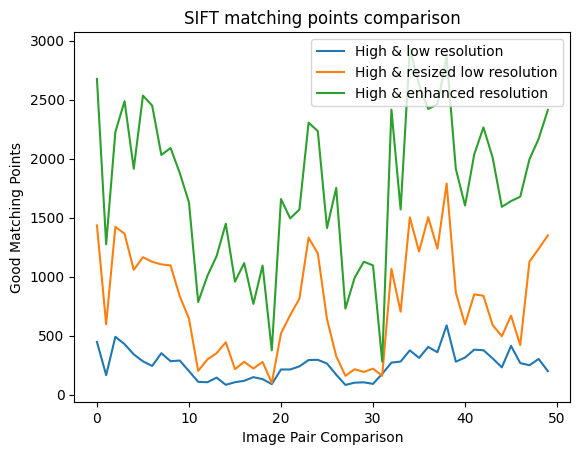

In [ ]:
import matplotlib.pyplot as plt

# Sample data for x-axis
x_values = list(range(50))


# Plotting the data
plt.plot(x_values, High_low_list, label='High & low resolution')
plt.plot(x_values, High_low512_list, label='High & resized low resolution')
plt.plot(x_values, High_Pred_list, label='High & enhanced resolution')

# Adding labels and title
plt.xlabel('Image Pair Comparison')
plt.ylabel('Good Matching Points')
plt.title('SIFT matching points comparison')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import random

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Copied256sizeImage/')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    random_number=i
    while random_number==i:
          random_number = random.randint(1, len(file_list_high)-1)
    filepath_sample='/content/drive/MyDrive/Copied256sizeImage/'+file_list_low[random_number]

    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:00<00:39,  1.24it/s]

good_matches 17


  4%|▍         | 2/50 [00:01<00:35,  1.35it/s]

good_matches 2


  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

good_matches 23


  8%|▊         | 4/50 [00:03<00:35,  1.29it/s]

good_matches 18


 10%|█         | 5/50 [00:04<00:38,  1.16it/s]

good_matches 11


 12%|█▏        | 6/50 [00:04<00:37,  1.18it/s]

good_matches 17


 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

good_matches 13


 16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

good_matches 38


 18%|█▊        | 9/50 [00:06<00:29,  1.38it/s]

good_matches 19


 20%|██        | 10/50 [00:07<00:28,  1.41it/s]

good_matches 13


 22%|██▏       | 11/50 [00:08<00:28,  1.38it/s]

good_matches 20


 24%|██▍       | 12/50 [00:08<00:26,  1.46it/s]

good_matches 81


 26%|██▌       | 13/50 [00:09<00:26,  1.41it/s]

good_matches 12


 28%|██▊       | 14/50 [00:10<00:24,  1.47it/s]

good_matches 6


 30%|███       | 15/50 [00:10<00:23,  1.51it/s]

good_matches 15


 32%|███▏      | 16/50 [00:11<00:20,  1.63it/s]

good_matches 6


 34%|███▍      | 17/50 [00:12<00:20,  1.58it/s]

good_matches 34


 38%|███▊      | 19/50 [00:12<00:15,  2.06it/s]

good_matches 11
good_matches 8


 40%|████      | 20/50 [00:13<00:15,  1.95it/s]

good_matches 19


 42%|████▏     | 21/50 [00:14<00:16,  1.73it/s]

good_matches 31


 44%|████▍     | 22/50 [00:14<00:16,  1.66it/s]

good_matches 16


 46%|████▌     | 23/50 [00:15<00:16,  1.65it/s]

good_matches 21


 48%|████▊     | 24/50 [00:16<00:16,  1.58it/s]

good_matches 12


 50%|█████     | 25/50 [00:16<00:15,  1.57it/s]

good_matches 35


 52%|█████▏    | 26/50 [00:17<00:15,  1.56it/s]

good_matches 33


 56%|█████▌    | 28/50 [00:18<00:10,  2.00it/s]

good_matches 9
good_matches 6


 58%|█████▊    | 29/50 [00:18<00:10,  1.95it/s]

good_matches 11


 62%|██████▏   | 31/50 [00:19<00:08,  2.35it/s]

good_matches 19
good_matches 9


 64%|██████▍   | 32/50 [00:20<00:08,  2.06it/s]

good_matches 13


 68%|██████▊   | 34/50 [00:21<00:07,  2.16it/s]

good_matches 24
good_matches 12


 70%|███████   | 35/50 [00:21<00:06,  2.47it/s]

good_matches 24


 72%|███████▏  | 36/50 [00:22<00:07,  1.97it/s]

good_matches 8


 74%|███████▍  | 37/50 [00:22<00:05,  2.33it/s]

good_matches 35


 76%|███████▌  | 38/50 [00:23<00:06,  2.00it/s]

good_matches 20


 78%|███████▊  | 39/50 [00:23<00:06,  1.66it/s]

good_matches 49


 82%|████████▏ | 41/50 [00:24<00:04,  2.04it/s]

good_matches 23
good_matches 20


 84%|████████▍ | 42/50 [00:25<00:03,  2.42it/s]

good_matches 69


 86%|████████▌ | 43/50 [00:25<00:02,  2.75it/s]

good_matches 31


 88%|████████▊ | 44/50 [00:25<00:02,  2.20it/s]

good_matches 32


 90%|█████████ | 45/50 [00:26<00:02,  2.07it/s]

good_matches 74


 92%|█████████▏| 46/50 [00:27<00:02,  1.93it/s]

good_matches 31


 94%|█████████▍| 47/50 [00:27<00:01,  2.04it/s]

good_matches 17


 96%|█████████▌| 48/50 [00:28<00:01,  1.82it/s]

good_matches 26


 98%|█████████▊| 49/50 [00:28<00:00,  2.21it/s]

good_matches 12


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]

good_matches 27


In [ ]:
High_low_list_1=[]
for i in range(len(good_matchesList)):
    High_low_list_1.append(len(good_matchesList[i]))

In [ ]:
High_low_list_1

[17,
 2,
 23,
 18,
 11,
 17,
 13,
 38,
 19,
 13,
 20,
 81,
 12,
 6,
 15,
 6,
 34,
 11,
 8,
 19,
 31,
 16,
 21,
 12,
 35,
 33,
 9,
 6,
 11,
 19,
 9,
 13,
 24,
 12,
 24,
 8,
 35,
 20,
 49,
 23,
 20,
 69,
 31,
 32,
 74,
 31,
 17,
 26,
 12,
 27]

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import random

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    random_number=i
    while random_number==i:
          random_number = random.randint(0, 50)
    filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Low/'+file_list_low[random_number]

    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:00<00:16,  2.99it/s]

good_matches 14


  4%|▍         | 2/50 [00:00<00:15,  3.11it/s]

good_matches 7


  6%|▌         | 3/50 [00:01<00:16,  2.80it/s]

good_matches 49


  8%|▊         | 4/50 [00:01<00:16,  2.84it/s]

good_matches 14


 10%|█         | 5/50 [00:01<00:14,  3.09it/s]

good_matches 16


 12%|█▏        | 6/50 [00:01<00:14,  3.07it/s]

good_matches 60


 14%|█▍        | 7/50 [00:02<00:13,  3.28it/s]

good_matches 33


 16%|█▌        | 8/50 [00:02<00:13,  3.11it/s]

good_matches 42


 18%|█▊        | 9/50 [00:02<00:13,  3.10it/s]

good_matches 34


 20%|██        | 10/50 [00:03<00:11,  3.37it/s]

good_matches 40


 22%|██▏       | 11/50 [00:03<00:11,  3.26it/s]

good_matches 28


 24%|██▍       | 12/50 [00:03<00:11,  3.34it/s]

good_matches 17


 26%|██▌       | 13/50 [00:04<00:10,  3.56it/s]

good_matches 3


 28%|██▊       | 14/50 [00:04<00:09,  3.61it/s]

good_matches 12


 30%|███       | 15/50 [00:04<00:09,  3.77it/s]

good_matches 69


 32%|███▏      | 16/50 [00:04<00:08,  4.04it/s]

good_matches 0


 34%|███▍      | 17/50 [00:04<00:07,  4.21it/s]

good_matches 32


 36%|███▌      | 18/50 [00:05<00:07,  4.00it/s]

good_matches 10


 40%|████      | 20/50 [00:05<00:06,  4.33it/s]

good_matches 9
good_matches 4


 42%|████▏     | 21/50 [00:05<00:07,  4.07it/s]

good_matches 47


 44%|████▍     | 22/50 [00:06<00:07,  3.78it/s]

good_matches 108


 46%|████▌     | 23/50 [00:06<00:07,  3.49it/s]

good_matches 45


 48%|████▊     | 24/50 [00:06<00:08,  3.15it/s]

good_matches 36


 50%|█████     | 25/50 [00:07<00:08,  3.02it/s]

good_matches 19


 52%|█████▏    | 26/50 [00:07<00:07,  3.24it/s]

good_matches 34


 56%|█████▌    | 28/50 [00:08<00:06,  3.53it/s]

good_matches 3
good_matches 14


 58%|█████▊    | 29/50 [00:08<00:05,  3.79it/s]

good_matches 37


 60%|██████    | 30/50 [00:08<00:05,  3.91it/s]

good_matches 9


 62%|██████▏   | 31/50 [00:08<00:04,  3.84it/s]

good_matches 9


 64%|██████▍   | 32/50 [00:09<00:04,  4.00it/s]

good_matches 19


 66%|██████▌   | 33/50 [00:09<00:04,  3.69it/s]

good_matches 9


 68%|██████▊   | 34/50 [00:09<00:04,  3.64it/s]

good_matches 7


 70%|███████   | 35/50 [00:10<00:04,  3.38it/s]

good_matches 10


 72%|███████▏  | 36/50 [00:10<00:04,  3.42it/s]

good_matches 42


 74%|███████▍  | 37/50 [00:10<00:04,  3.08it/s]

good_matches 40


 76%|███████▌  | 38/50 [00:11<00:03,  3.01it/s]

good_matches 49


 78%|███████▊  | 39/50 [00:11<00:03,  2.98it/s]

good_matches 49


 80%|████████  | 40/50 [00:11<00:03,  3.01it/s]

good_matches 61


 82%|████████▏ | 41/50 [00:12<00:03,  2.97it/s]

good_matches 66


 84%|████████▍ | 42/50 [00:12<00:02,  3.02it/s]

good_matches 37


 86%|████████▌ | 43/50 [00:12<00:02,  3.05it/s]

good_matches 52


 88%|████████▊ | 44/50 [00:13<00:01,  3.14it/s]

good_matches 68


 90%|█████████ | 45/50 [00:13<00:01,  3.15it/s]

good_matches 9


 92%|█████████▏| 46/50 [00:13<00:01,  3.46it/s]

good_matches 149


 94%|█████████▍| 47/50 [00:13<00:00,  3.69it/s]

good_matches 17


 96%|█████████▌| 48/50 [00:14<00:00,  3.78it/s]

good_matches 34


 98%|█████████▊| 49/50 [00:14<00:00,  3.66it/s]

good_matches 15


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]

good_matches 17


In [ ]:
High_low512_list_1=[]
for i in range(len(good_matchesList)):
    High_low512_list_1.append(len(good_matchesList[i]))

In [ ]:
High_low512_list_1

[14,
 7,
 49,
 14,
 16,
 60,
 33,
 42,
 34,
 40,
 28,
 17,
 3,
 12,
 69,
 0,
 32,
 10,
 9,
 4,
 47,
 108,
 45,
 36,
 19,
 34,
 3,
 14,
 37,
 9,
 9,
 19,
 9,
 7,
 10,
 42,
 40,
 49,
 49,
 61,
 66,
 37,
 52,
 68,
 9,
 149,
 17,
 34,
 15,
 17]

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import random

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
file_list_low = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred/')


for i in tqdm(range(len(file_list_high)-1)[:50]):
    filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/'+file_list_high[i]
    random_number=i
    while random_number==i:
          random_number = random.randint(0, 50)
    filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred/'+file_list_low[random_number]

    sample_1=cv2.imread(filepath)
    sample=cv2.imread(filepath_sample)
    #cv2_imshow(sample_1)
    #cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
    flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

            # Draw the matches
    result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
    print("good_matches",len(good_matches))

            # Show the result
    #cv2_imshow(result_image)

    #keypoint1List.append(keypoint1)
    #keypoint2List.append(keypoint2)
    good_matchesList.append(good_matches)

  2%|▏         | 1/50 [00:00<00:20,  2.38it/s]

good_matches 42


  4%|▍         | 2/50 [00:00<00:18,  2.65it/s]

good_matches 8


  6%|▌         | 3/50 [00:01<00:19,  2.46it/s]

good_matches 17


  8%|▊         | 4/50 [00:01<00:17,  2.67it/s]

good_matches 6


 10%|█         | 5/50 [00:01<00:15,  2.86it/s]

good_matches 15


 12%|█▏        | 6/50 [00:02<00:16,  2.70it/s]

good_matches 38


 14%|█▍        | 7/50 [00:02<00:16,  2.59it/s]

good_matches 25


 16%|█▌        | 8/50 [00:03<00:16,  2.57it/s]

good_matches 19


 18%|█▊        | 9/50 [00:03<00:16,  2.52it/s]

good_matches 19


 20%|██        | 10/50 [00:03<00:15,  2.53it/s]

good_matches 57


 22%|██▏       | 11/50 [00:04<00:14,  2.69it/s]

good_matches 23


 24%|██▍       | 12/50 [00:04<00:13,  2.82it/s]

good_matches 7


 26%|██▌       | 13/50 [00:04<00:12,  2.87it/s]

good_matches 8


 28%|██▊       | 14/50 [00:05<00:11,  3.07it/s]

good_matches 10


 30%|███       | 15/50 [00:05<00:10,  3.24it/s]

good_matches 28


 32%|███▏      | 16/50 [00:05<00:10,  3.09it/s]

good_matches 11


 34%|███▍      | 17/50 [00:06<00:10,  3.02it/s]

good_matches 14


 36%|███▌      | 18/50 [00:06<00:10,  3.12it/s]

good_matches 2


 38%|███▊      | 19/50 [00:06<00:09,  3.33it/s]

good_matches 31


 40%|████      | 20/50 [00:06<00:08,  3.45it/s]

good_matches 1


 42%|████▏     | 21/50 [00:07<00:09,  3.20it/s]

good_matches 51


 44%|████▍     | 22/50 [00:07<00:09,  3.01it/s]

good_matches 46


 46%|████▌     | 23/50 [00:07<00:08,  3.21it/s]

good_matches 16


 48%|████▊     | 24/50 [00:08<00:08,  3.25it/s]

good_matches 38


 50%|█████     | 25/50 [00:08<00:08,  2.91it/s]

good_matches 46


 52%|█████▏    | 26/50 [00:09<00:14,  1.63it/s]

good_matches 20


 54%|█████▍    | 27/50 [00:10<00:12,  1.87it/s]

good_matches 15


 56%|█████▌    | 28/50 [00:10<00:10,  2.15it/s]

good_matches 5


 58%|█████▊    | 29/50 [00:10<00:09,  2.30it/s]

good_matches 15


 60%|██████    | 30/50 [00:11<00:08,  2.48it/s]

good_matches 8


 62%|██████▏   | 31/50 [00:11<00:07,  2.55it/s]

good_matches 10


 64%|██████▍   | 32/50 [00:11<00:06,  2.98it/s]

good_matches 18


 66%|██████▌   | 33/50 [00:12<00:06,  2.82it/s]

good_matches 6


 68%|██████▊   | 34/50 [00:12<00:05,  2.92it/s]

good_matches 8


 70%|███████   | 35/50 [00:12<00:05,  2.60it/s]

good_matches 22


 72%|███████▏  | 36/50 [00:13<00:05,  2.49it/s]

good_matches 7


 74%|███████▍  | 37/50 [00:13<00:05,  2.53it/s]

good_matches 25


 76%|███████▌  | 38/50 [00:14<00:04,  2.65it/s]

good_matches 20


 78%|███████▊  | 39/50 [00:14<00:03,  2.77it/s]

good_matches 13


 80%|████████  | 40/50 [00:14<00:03,  2.75it/s]

good_matches 43


 82%|████████▏ | 41/50 [00:15<00:03,  2.73it/s]

good_matches 52


 84%|████████▍ | 42/50 [00:15<00:02,  2.82it/s]

good_matches 10


 86%|████████▌ | 43/50 [00:15<00:02,  2.86it/s]

good_matches 16


 88%|████████▊ | 44/50 [00:16<00:02,  2.73it/s]

good_matches 49


 90%|█████████ | 45/50 [00:16<00:01,  2.79it/s]

good_matches 17


 92%|█████████▏| 46/50 [00:16<00:01,  2.75it/s]

good_matches 26


 94%|█████████▍| 47/50 [00:17<00:01,  2.96it/s]

good_matches 13


 96%|█████████▌| 48/50 [00:17<00:00,  3.00it/s]

good_matches 13


 98%|█████████▊| 49/50 [00:18<00:00,  2.81it/s]

good_matches 14


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

good_matches 12


In [ ]:
High_Pred_list_1=[]
for i in range(len(good_matchesList)):
    High_Pred_list_1.append(len(good_matchesList[i]))

In [ ]:
High_Pred_list_1

[42,
 8,
 17,
 6,
 15,
 38,
 25,
 19,
 19,
 57,
 23,
 7,
 8,
 10,
 28,
 11,
 14,
 2,
 31,
 1,
 51,
 46,
 16,
 38,
 46,
 20,
 15,
 5,
 15,
 8,
 10,
 18,
 6,
 8,
 22,
 7,
 25,
 20,
 13,
 43,
 52,
 10,
 16,
 49,
 17,
 26,
 13,
 13,
 14,
 12]

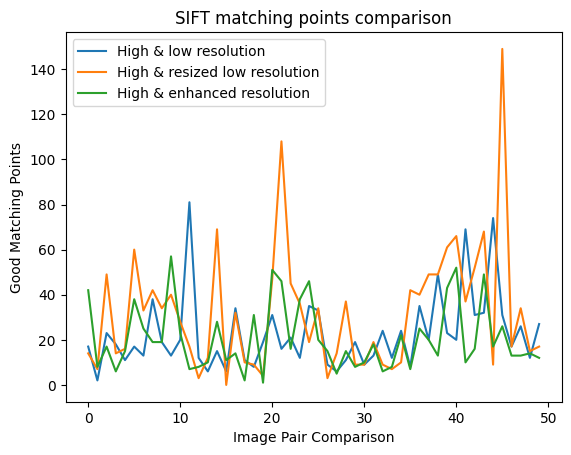

In [ ]:
import matplotlib.pyplot as plt

# Sample data for x-axis
x_values = list(range(50))


# Plotting the data
plt.plot(x_values, High_low_list_1, label='High & low resolution')
plt.plot(x_values, High_low512_list_1, label='High & resized low resolution')
plt.plot(x_values, High_Pred_list_1, label='High & enhanced resolution')

# Adding labels and title
plt.xlabel('Image Pair Comparison')
plt.ylabel('Good Matching Points')
plt.title('SIFT matching points comparison')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

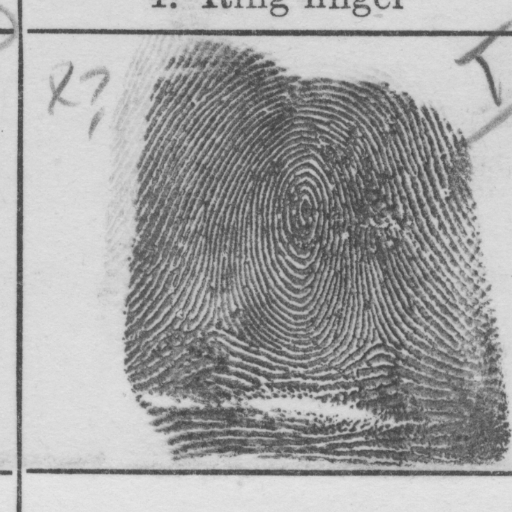

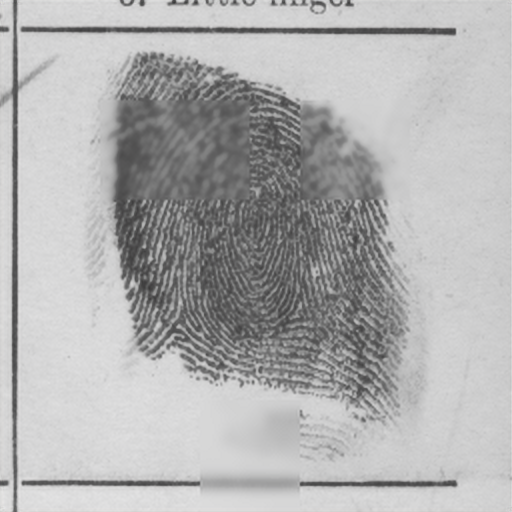

good_matches 42


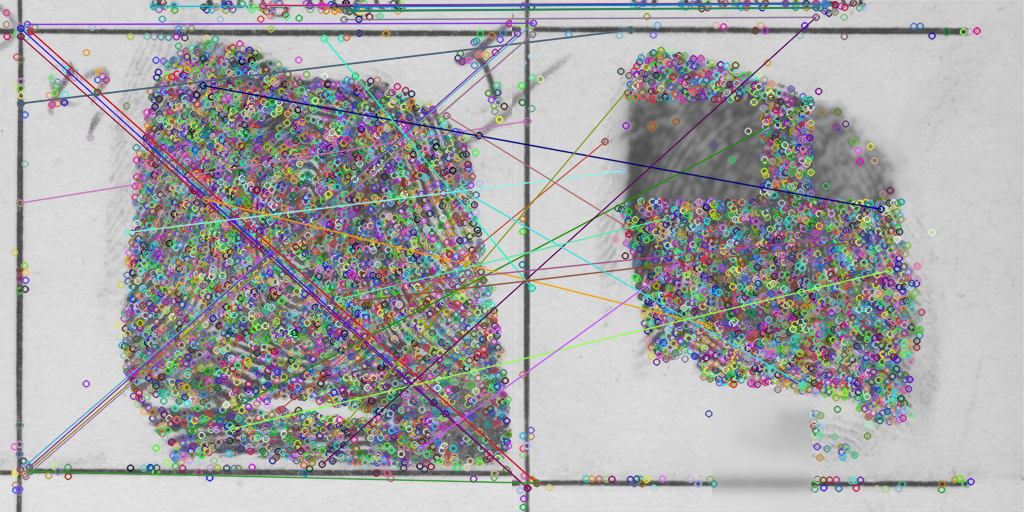

In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
#model = load_model('/content/drive/MyDrive/Model/SRCNN_NIST_Without_THR.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

keypoint1List=[]
keypoint2List=[]
good_matchesList=[]
best_score=0
filename=None
image =None
kp1,kp2, mp= None, None, None

#file_list_high = os.listdir('/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/')
#file_list_low = os.listdir('/content/drive/MyDrive/Roll_256_damage_final')



filepath='/content/drive/MyDrive/Testing_Without_THR_SRCNN/High/00001000_roll_500_04.png'
#cv2_imshow(filepath)
filepath_sample='/content/drive/MyDrive/Testing_Without_THR_SRCNN/Pred/00001000_roll_500_05.png'
#cv2_imshow(filepath_sample)
sample_1=cv2.imread(filepath)
sample=cv2.imread(filepath_sample)
cv2_imshow(sample_1)
cv2_imshow(sample)
    #sample.resize(256,256)
    #print(filepath)
sift = cv2.SIFT_create()
keypoint1, descriptor1 = sift.detectAndCompute(sample_1, None)
keypoint2, descriptor2 = sift.detectAndCompute(sample, None)
    #print(f"keypoint1=>{len(keypoint1)}")
    #print(f"keypoint2=>{len(keypoint2)}")
            # FLANN parameters
flann_params = {
                'algorithm': 1,  # FLANN_INDEX_KDTREE
                'trees': 10
            }

            # Create FLANN matcher
flann = cv2.FlannBasedMatcher(flann_params, {})
            # Perform KNN matching
matches = flann.knnMatch(descriptor1, descriptor2, k=2)

                    # Filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
      good_matches.append(m)

            # Draw the matches
result_image = cv2.drawMatches(sample_1, keypoint1, sample, keypoint2, good_matches, None)
print("good_matches",len(good_matches))

            # Show the result
cv2_imshow(result_image)